In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from pykalman import KalmanFilter
import numpy as np
from sklearn.metrics import mean_squared_error

In [3]:
file_path = "datasets/other/test_data.csv"  # Update with the correct file path if necessary
df = pd.read_csv(file_path)

In [4]:
df['theta_filtered'] = medfilt(df['theta'], kernel_size=15)

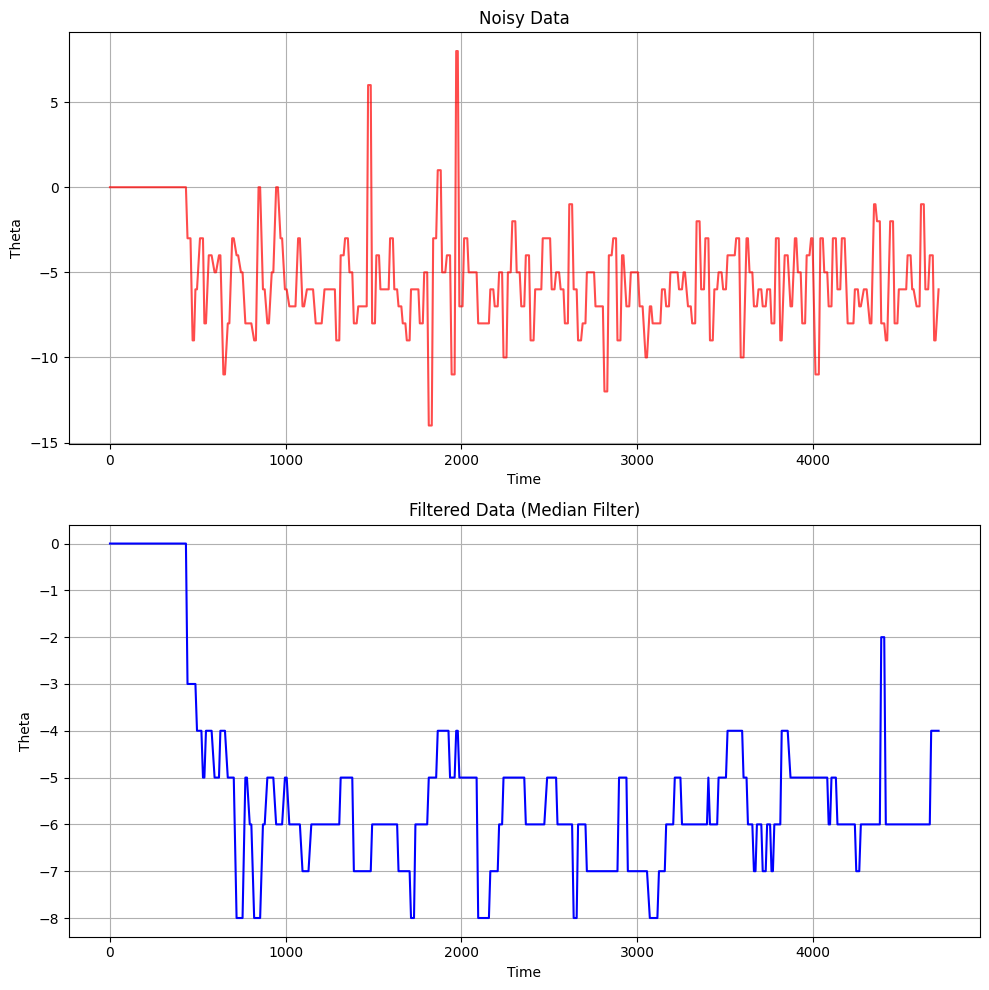

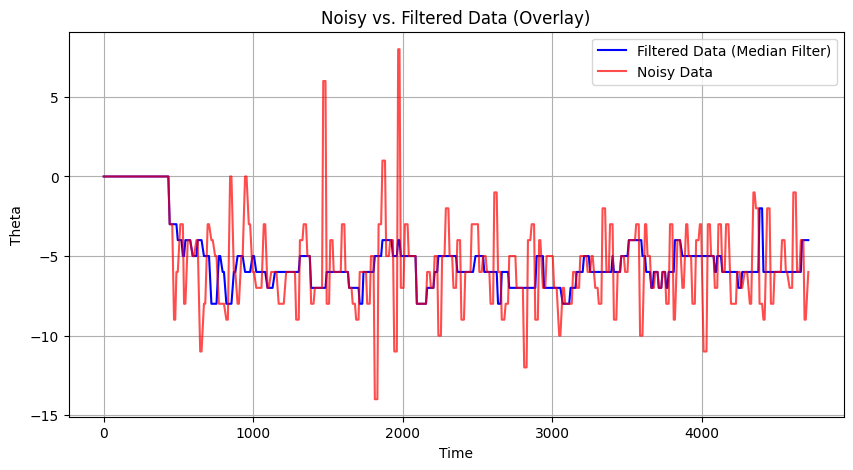

In [5]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot Noisy Data
axes[0].plot(df['time'], df['theta'], color='red', alpha=0.7)
axes[0].set_title("Noisy Data")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Theta")
axes[0].grid()

# Plot Filtered Data
axes[1].plot(df['time'], df['theta_filtered'], color='blue')
axes[1].set_title("Filtered Data (Median Filter)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Theta")
axes[1].grid()

# Show the separate plots
plt.tight_layout()
plt.show()

# Overlay Noisy and Filtered Data in One Plot
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['theta_filtered'], label='Filtered Data (Median Filter)', color='blue')
plt.plot(df['time'], df['theta'], label='Noisy Data', color='red', alpha=0.7)


# Labels and title
plt.xlabel('Time')
# plt.xlim([1000, 1050])
plt.ylabel('Theta')
plt.title('Noisy vs. Filtered Data (Overlay)')
plt.legend()
plt.grid()

# Show the overlay plot
plt.show()

In [6]:
# Apply Exponential Moving Average (EMA) to the 'theta' column
alpha = 0.1  # Smoothing factor
df['theta_ema'] = df['theta'].ewm(alpha=alpha, adjust=False).mean()

In [7]:
window_size = 60  # Adjust window size as needed
df['theta_sma'] = df['theta'].rolling(window=window_size).mean()

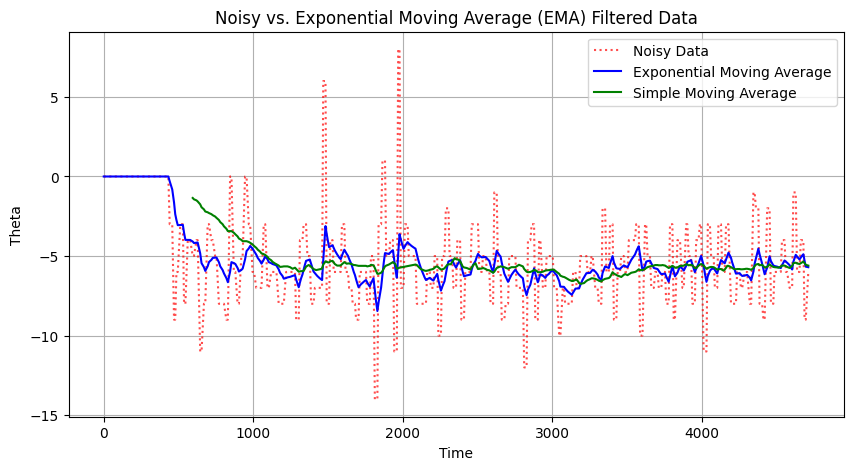

In [8]:
# Plot the original (noisy) data and EMA filtered data
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['theta'], label='Noisy Data', linestyle='dotted', color='red', alpha=0.7)
plt.plot(df['time'], df['theta_ema'], label='Exponential Moving Average', color='blue')
plt.plot(df['time'], df['theta_sma'], label='Simple Moving Average', color='green')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Noisy vs. Exponential Moving Average (EMA) Filtered Data')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [9]:
# Initialize Kalman Filter parameters
kf_at = KalmanFilter(initial_state_mean=[df['theta'].iloc[0]],
                  n_dim_obs=1)

# Estimate transition and observation matrices automatically
kf_at= kf_at.em(df['theta'], n_iter=10)

# Apply the Kalman filter to smooth the 'theta' values
df['theta_kalman_at'], _ = kf_at.smooth(df['theta'])

In [10]:
# Manually set Q and R
Q_value = 8e-4  # Process noise (Try 1e-4, 1e-3, etc.)
R_value = 0.08  # Measurement noise (Try 0.01, 1.0, etc.)

kf = KalmanFilter(
    initial_state_mean=[df['theta'].iloc[0]],
    transition_matrices=[1],  # Assumes state transition is 1: x_k = x_{k-1}
    observation_matrices=[1],  # Measurement is directly related to state
    transition_covariance=[[Q_value]],  # Process noise
    observation_covariance=[[R_value]]  # Measurement noise
)

# Apply Kalman filter
df['theta_kalman'], _ = kf.smooth(df['theta'])

In [11]:
# Print estimated Q (Process Noise Covariance)
print("Estimated Process Noise Covariance (Q):")
print(kf.transition_covariance)

# Print estimated R (Measurement Noise Covariance)
print("\nEstimated Measurement Noise Covariance (R):")
print(kf.observation_covariance)

Estimated Process Noise Covariance (Q):
[[0.0008]]

Estimated Measurement Noise Covariance (R):
[[0.08]]


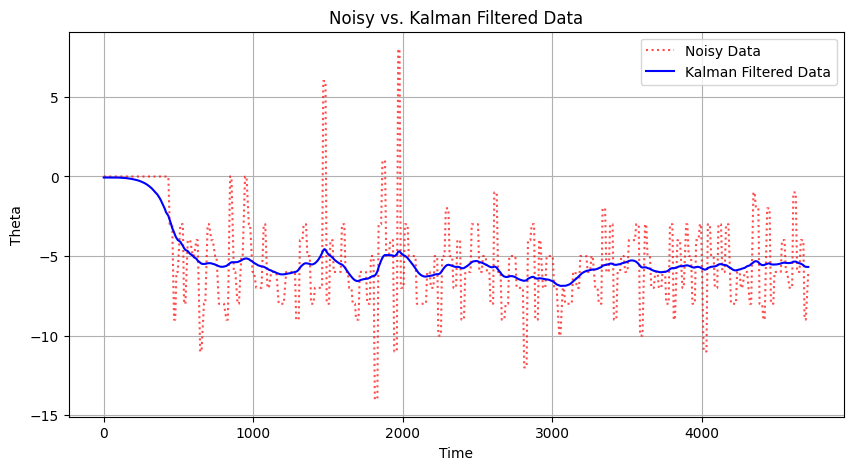

In [12]:
# Plot the original (noisy) data and Kalman filtered data
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['theta'], label='Noisy Data', linestyle='dotted', color='red', alpha=0.7)
plt.plot(df['time'], df['theta_kalman'], label='Kalman Filtered Data', color='blue')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Noisy vs. Kalman Filtered Data')
plt.legend()
plt.grid()

# Show the plot
plt.show()

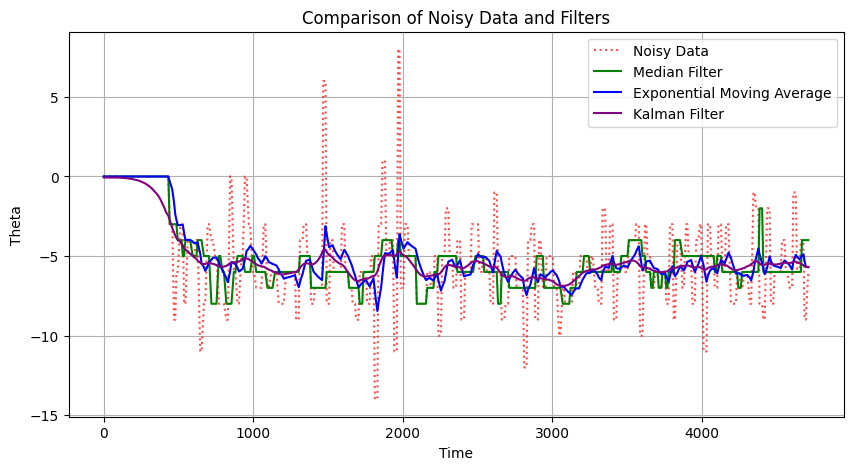

In [13]:
# Plot all filters over each other
plt.figure(figsize=(10, 5))

plt.plot(df['time'], df['theta'], label='Noisy Data', linestyle='dotted', color='red', alpha=0.7)
plt.plot(df['time'], df['theta_filtered'], label='Median Filter', color='green')
plt.plot(df['time'], df['theta_ema'], label='Exponential Moving Average', color='blue')
plt.plot(df['time'], df['theta_kalman'], label='Kalman Filter', color='purple')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Comparison of Noisy Data and Filters')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [14]:
mse_median = mean_squared_error(df['theta'], df['theta_filtered'])
mse_ema = mean_squared_error(df['theta'], df['theta_ema'])
mse_kalman = mean_squared_error(df['theta'], df['theta_kalman'])

print(f"MSE - Median Filter: {mse_median:.4f}")
print(f"MSE - EMA: {mse_ema:.4f}")
print(f"MSE - Kalman Filter: {mse_kalman:.4f}")

MSE - Median Filter: 7.0263
MSE - EMA: 5.8155
MSE - Kalman Filter: 6.0670


In [15]:
def snr(signal, noise):
    return 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))

snr_median = snr(df['theta'], df['theta'] - df['theta_filtered'])
snr_ema = snr(df['theta'], df['theta'] - df['theta_ema'])
snr_kalman = snr(df['theta'], df['theta'] - df['theta_kalman'])

print(f"SNR - Median Filter: {snr_median:.2f} dB")
print(f"SNR - EMA: {snr_ema:.2f} dB")
print(f"SNR - Kalman Filter: {snr_kalman:.2f} dB")

SNR - Median Filter: 7.19 dB
SNR - EMA: 8.01 dB
SNR - Kalman Filter: 7.83 dB


In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Path to the CSV file
csv_file_path = 'test_data.csv'

# Read the data from the CSV file
df = pd.read_csv(csv_file_path)

# Convert 'time' from milliseconds to seconds for plotting
df['time_seconds'] = df['time'] / 1000

def apply_kalman_filter(data, process_variance, observation_variance):
    measurements = data['theta'].values
    
    kf = KalmanFilter(
        initial_state_mean=measurements[0],
        initial_state_covariance=1.0,
        transition_matrices=1.0,  
        observation_matrices=1.0,  
        transition_covariance=process_variance,  
        observation_covariance=observation_variance,
    )
    
    # Filter the data
    filtered_state_means, filtered_state_covariances = kf.smooth(measurements)

    # Calculate metrics
    mse = mean_squared_error(measurements, filtered_state_means)
    
    return filtered_state_means, mse

def apply_exponential_moving_average(data, alpha):
    ema = data['theta'].ewm(alpha=alpha).mean()
    return ema

def apply_moving_average(data, window_size):
    ma = data['theta'].rolling(window=window_size).mean()
    return ma

# Apply filters
filtered_state_means, mse = apply_kalman_filter(df, process_variance=0.001, observation_variance=0.1)

# ema = apply_exponential_moving_average(df, alpha=0.6)

# ma = apply_moving_average(df, window_size=5)

print("Filtered State Means:", filtered_state_means)
print("Mean Squared Error:", mse)

# Plot the original and filtered data
plt.figure(figsize=(10, 5))
plt.plot(df['time_seconds'], df['theta'], label='Original Theta')
plt.plot(df['time_seconds'], filtered_state_means, label='Kalman Filtered Theta')
# plt.plot(df['time_seconds'], ema, label='Exponential Moving Average')
# plt.plot(df['time_seconds'], ma, label='Moving Average')
plt.xlabel('Time (s)')
plt.ylabel('Theta')
plt.title('Theta over Time')
plt.legend()
plt.grid(True)

# Set the y-axis labels to display every second
plt.yticks(range(0, int(df['time_seconds'].max()) + 1, 1))

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'test_data.csv'